In [1]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import EvaluationModule
pd.options.mode.chained_assignment = None

(CVXPY) Jul 11 10:37:44 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 11 10:37:44 PM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 11 10:37:44 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="binary_classification", #option: regression, regression_delta, classification, binary_classification
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation="IterativeImputer", #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    remove_low_DAS = True,
    save_csv=False,
    balance_class=True,
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Missing values in train before imputation: 128
Missing values in train after imputation: 0
Missing values in test before imputation: 24
Missing values in test after imputation: 0
Label Encoder, 0: Non-responders (No Response), 1: Responders(Good, Moderate)
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Train.csv
Label Encoder, 0: Non-responders (No Response), 1: Responders(Good, Moderate)
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Test.csv
1.0    204
0.0    184
Name: DrugResponse_binary, dtype: int64


In [4]:
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [5]:
train.head(10)

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DrugResponse_binary
0,1,0,61.0,0,0,7,1,240.0,39.933728,65.0,...,55.0,50.0,0.250000,60.0,1.00,44.0,948.0,51.0,3.719481,0.0
1,1,0,50.0,0,0,7,1,250.0,39.151259,67.0,...,35.0,27.0,0.500000,20.0,1.33,402.0,1290.0,89.0,3.809990,0.0
2,2,0,69.0,1,4,7,1,127.0,17.710970,71.0,...,50.0,40.0,0.571429,70.0,12.89,551.0,672.0,51.0,4.465034,0.0
3,1,0,61.0,0,2,7,1,145.0,26.517950,62.0,...,40.0,5.0,0.857143,60.0,1.31,164.0,902.0,72.0,3.439129,0.0
4,2,0,75.0,0,4,7,1,164.0,27.288047,65.0,...,50.0,50.0,0.857143,80.0,14.15,280.0,1520.0,211.0,4.963210,0.0
5,2,0,45.0,0,0,7,1,254.0,35.421940,71.0,...,50.0,55.0,0.500000,50.0,11.96,293.0,1270.0,112.0,4.332272,0.0
6,1,0,58.0,0,0,7,1,212.0,32.230969,68.0,...,10.0,30.0,0.000000,40.0,4.69,195.0,780.0,63.0,3.937650,0.0
7,2,0,51.0,1,0,7,1,282.0,36.202703,74.0,...,40.0,25.0,0.571429,65.0,2.30,85.0,1140.0,88.0,3.344786,0.0
8,2,0,48.0,1,2,1,1,175.0,24.404880,71.0,...,40.0,70.0,1.285714,80.0,12.45,159.0,1290.0,107.0,4.983352,0.0
9,2,0,54.0,0,1,7,1,268.0,37.374330,71.0,...,50.0,70.0,1.142857,80.0,10.75,195.0,1110.0,150.0,4.819996,0.0


In [6]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train_h2o = h2o.upload_file(str(train_loc))
test_h2o = h2o.upload_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = "DrugResponse_binary"

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 mins 46 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_gaskell_cuecn0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.996 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
train_h2o

grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,drinker,drinksperwk,duration_ra,ara_func_class,num_tnf,num_nontnf,ndmardused,rfstatus_b,usresultsRF,ccpstatus_b,usresultsCCP3,hxmi,hxunstab_ang,hxchf,hxother_cv,hxtia,hxstroke,hxcopd,hxhtn,hxdiabetes,hxhld,hx_anycancer,seatedbp1,seatedbp2,pres_mtx,pres_arava,pres_azulfidine,pres_plaquenil,pres_imuran,pres_minocin,pres_pred,nonpresNSAIDs_use,NSAIDs_use,tender_jts_28,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DrugResponse_binary
1,0,61,0,0,7,1,240,39.9337,65,2,2,0.466667,1,0,0,0,1,0,9.8,0,15,0,0,0,0,0,0,0,0,1,0,0,110,80,1,0,0,0,0,0,1,0,0,3,9,55,50,0.25,60,1,44,948,51,3.71948,0
1,0,64,1,0,7,1,294,41.0002,71,2,2,2,2,1,0,0,1,0,8.7,0,15,0,0,0,0,0,0,0,0,0,0,0,137,87,1,0,0,0,0,0,0,0,1,6,13,55,55,0.285714,70,16.74,178,882,87,5.14656,1
2,0,51,0,2,7,1,90,18.1758,59,0,1,0,5,1,0,0,1,1,30.5,1,174,0,0,0,0,0,0,0,0,0,0,0,100,70,1,0,0,0,0,0,1,0,0,14,13,65,20,0.25,65,0.25,155,824,43,4.42521,1
3,0,57,0,0,7,1,161,30.4174,61,3,1,0,3,1,0,0,1,1,110.2,1,251,0,0,0,0,0,0,0,1,0,1,0,132,79,1,0,0,0,0,0,1,0,0,9,9,70,55,1,65,10.6374,273,714,138,5.13352,1
2,0,62,0,0,7,1,150,26.5684,63,2,2,14,2,1,0,0,1,0,9.4,0,15,0,0,0,0,0,0,0,1,0,0,0,112,75,1,0,0,0,0,0,0,0,0,12,12,50,25,0,20,17.93,171,992,95,5.27851,1
1,0,54,1,2,7,1,182,25.3811,71,0,2,0.466667,2,0,0,0,1,1,750,1,251,0,0,0,0,0,0,0,0,0,0,0,119,76,1,0,0,0,0,0,0,0,0,5,5,40,10,0.142857,5,4.7,267,1110,109,3.60486,1
1,0,50,0,0,7,1,250,39.1513,67,2,2,0.466667,0,1,0,0,1,1,92.4,1,73,0,0,0,0,0,0,0,0,0,0,0,110,80,0,0,0,0,0,0,0,0,0,7,6,35,27,0.5,20,1.33,402,1290,89,3.80999,0
1,0,37,0,0,7,1,198,32.9453,65,0,2,0.466667,0,1,0,0,0,0,8.5,0,15,0,0,0,0,0,0,0,0,0,0,0,137,81,0,0,0,0,0,0,1,1,0,13,6,44,85,1.5,80,11.78,200,917,180,5.7722,1
1,0,73,0,2,7,1,204,37.308,62,3,1,0,4,1,0,0,2,1,259.3,1,188,0,0,0,0,0,0,0,1,1,0,0,177,100,0,0,1,1,0,0,1,1,0,2,7,40,35,1.125,25,22.06,238,562,34,4.11249,1
1,0,60,0,0,7,1,184,29.6951,66,3,2,0.466667,8,1,0,0,2,1,61,0,15,0,0,0,0,0,0,0,0,0,1,0,141,100,1,0,0,0,0,0,0,1,1,11,6,45,65,0.5,60,1.5,259,981,54,4.74303,1


In [8]:
for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
train_h2o[y] = train_h2o[y].asfactor()
test_h2o[y] = test_h2o[y].asfactor()

In [9]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "SC_classification_Jul9")
aml.train(x=x, y=y, training_frame=train_h2o, leaderboard_frame = test_h2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
22:37:56.876: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]


22:37:58.664: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

██
22:38:00.300: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
22:38:01.732: _train param, Dropping unused columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
22:38:02.477: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
22:38:03.286: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
22:38:04.307: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
22:38:05.235: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group,

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20220711_223756_model_8,0.725333,0.579793,0.867561,0.46,0.441597,0.195008
XGBoost_3_AutoML_1_20220711_223756,0.717333,0.601234,0.845107,0.35,0.442534,0.195837
DeepLearning_grid_1_AutoML_1_20220711_223756_model_1,0.670667,1.65795,0.754919,0.36,0.480017,0.230416
XGBoost_grid_1_AutoML_1_20220711_223756_model_13,0.660667,0.689426,0.770576,0.428333,0.451764,0.204091
XGBoost_grid_1_AutoML_1_20220711_223756_model_16,0.659333,0.60839,0.796317,0.46,0.450813,0.203233
DeepLearning_grid_1_AutoML_1_20220711_223756_model_2,0.657333,2.90018,0.740681,0.368333,0.487379,0.237539
GBM_grid_1_AutoML_1_20220711_223756_model_3,0.656667,0.595816,0.822009,0.468333,0.451436,0.203795
GBM_grid_1_AutoML_1_20220711_223756_model_1,0.656,0.611697,0.806392,0.48,0.458103,0.209859
XGBoost_grid_1_AutoML_1_20220711_223756_model_2,0.656,0.621172,0.82151,0.5,0.459108,0.210781
DeepLearning_grid_1_AutoML_1_20220711_223756_model_5,0.654,0.857519,0.741496,0.376667,0.452738,0.204972


In [10]:
lb['model_id']

model_id
GBM_grid_1_AutoML_1_20220711_223756_model_8
XGBoost_3_AutoML_1_20220711_223756
DeepLearning_grid_1_AutoML_1_20220711_223756_model_1
XGBoost_grid_1_AutoML_1_20220711_223756_model_13
XGBoost_grid_1_AutoML_1_20220711_223756_model_16
DeepLearning_grid_1_AutoML_1_20220711_223756_model_2
GBM_grid_1_AutoML_1_20220711_223756_model_3
GBM_grid_1_AutoML_1_20220711_223756_model_1
XGBoost_grid_1_AutoML_1_20220711_223756_model_2
DeepLearning_grid_1_AutoML_1_20220711_223756_model_5


In [11]:
# aml_sc = EvaluationModule.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge)
# test, test_loc = dataset.get_test()

# for model in lb.as_data_frame()['model_id']:
#     m = h2o.get_model(model)
#     pred = m.predict(test_h2o).as_data_frame()
#     aml_sc.evaluate(model, test, pred)

In [12]:
# aml_sc = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
# test, test_loc = dataset.get_test()
# baseline = test['DAS28_CRP_0M']
# true = test['DAS28_CRP_3M']

In [13]:
# pred = pred.as_data_frame()

In [14]:
# aml_sc.evaluate("stackedensemble", test, pred)

In [15]:
# regression, classification = aml_sc.leaderboard()

In [16]:
# regression

In [17]:
# classification.sort_values('Accuracy',ascending=False)

In [18]:
gbm = H2OGradientBoostingEstimator(nfolds = 5, seed = 1)
gbm.train(x=x, y=y, training_frame=train_h2o)

gbm Model Build progress: |

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1657593186997_5009


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,11161.0,5.0,5.0,5.0,7.0,19.0,13.12




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.015797027395286354
RMSE: 0.12568622595688977
LogLoss: 0.10427694065337094
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7470543821194214: 


,,0,1,Error,Rate
0,0,73.0,0.0,0.0,(0.0/73.0)
1,1,0.0,231.0,0.0,(0.0/231.0)
2,Total,73.0,231.0,0.0,(0.0/304.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.747054,1.000000,230.0
1,max f2,0.747054,1.000000,230.0
2,max f0point5,0.747054,1.000000,230.0
3,max accuracy,0.747054,1.000000,230.0
4,max precision,0.992883,1.000000,0.0
5,max recall,0.747054,1.000000,230.0
6,max specificity,0.992883,1.000000,0.0
7,max absolute_mcc,0.747054,1.000000,230.0
8,max min_per_class_accuracy,0.747054,1.000000,230.0
9,max mean_per_class_accuracy,0.747054,1.000000,230.0



Gains/Lift Table: Avg response rate: 75.99 %, avg score: 75.93 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013158,0.983622,1.316017,1.316017,1.0,0.986901,1.000000,0.986901,0.017316,0.017316,31.601732,31.601732,0.017316
1,2,0.023026,0.979395,1.316017,1.316017,1.0,0.980383,1.000000,0.984107,0.012987,0.030303,31.601732,31.601732,0.030303
2,3,0.032895,0.977820,1.316017,1.316017,1.0,0.978600,1.000000,0.982455,0.012987,0.043290,31.601732,31.601732,0.043290
3,4,0.042763,0.977458,1.316017,1.316017,1.0,0.977546,1.000000,0.981322,0.012987,0.056277,31.601732,31.601732,0.056277
4,5,0.052632,0.975871,1.316017,1.316017,1.0,0.976401,1.000000,0.980399,0.012987,0.069264,31.601732,31.601732,0.069264
5,6,0.101974,0.971178,1.316017,1.316017,1.0,0.973584,1.000000,0.977102,0.064935,0.134199,31.601732,31.601732,0.134199
6,7,0.151316,0.967754,1.316017,1.316017,1.0,0.969111,1.000000,0.974496,0.064935,0.199134,31.601732,31.601732,0.199134
7,8,0.200658,0.964122,1.316017,1.316017,1.0,0.966285,1.000000,0.972477,0.064935,0.264069,31.601732,31.601732,0.264069
8,9,0.299342,0.955673,1.316017,1.316017,1.0,0.960316,1.000000,0.968468,0.129870,0.393939,31.601732,31.601732,0.393939
9,10,0.401316,0.946425,1.316017,1.316017,1.0,0.950834,1.000000,0.963987,0.134199,0.528139,31.601732,31.601732,0.528139




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.1972026067185403
RMSE: 0.4440750012312563
LogLoss: 0.6255679735838983
Mean Per-Class Error: 0.4653976160825476
AUC: 0.6127023661270237
AUCPR: 0.806866233514425
Gini: 0.22540473225404734

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25610356939098455: 


,,0,1,Error,Rate
0,0,6.0,67.0,0.9178,(67.0/73.0)
1,1,3.0,228.0,0.013,(3.0/231.0)
2,Total,9.0,295.0,0.2303,(70.0/304.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.256104,0.866920,294.0
1,max f2,0.111156,0.942088,301.0
2,max f0point5,0.256104,0.807938,294.0
3,max accuracy,0.256104,0.769737,294.0
4,max precision,0.992340,1.000000,0.0
5,max recall,0.111156,1.000000,301.0
6,max specificity,0.992340,1.000000,0.0
7,max absolute_mcc,0.919012,0.196689,122.0
8,max min_per_class_accuracy,0.884903,0.567100,161.0
9,max mean_per_class_accuracy,0.919012,0.612999,122.0



Gains/Lift Table: Avg response rate: 75.99 %, avg score: 79.77 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013158,0.986813,0.658009,0.658009,0.500000,0.988462,0.500000,0.988462,0.008658,0.008658,-34.199134,-34.199134,-0.018739
1,2,0.023026,0.984274,0.877345,0.752010,0.666667,0.984513,0.571429,0.986769,0.008658,0.017316,-12.265512,-24.799011,-0.023780
2,3,0.032895,0.982103,1.316017,0.921212,1.000000,0.982962,0.700000,0.985627,0.012987,0.030303,31.601732,-7.878788,-0.010793
3,4,0.042763,0.979859,1.316017,1.012321,1.000000,0.980626,0.769231,0.984473,0.012987,0.043290,31.601732,1.232101,0.002194
4,5,0.052632,0.977597,0.877345,0.987013,0.666667,0.978627,0.750000,0.983377,0.008658,0.051948,-12.265512,-1.298701,-0.002846
5,6,0.101974,0.969778,1.140548,1.061304,0.866667,0.973293,0.806452,0.978497,0.056277,0.108225,14.054834,6.130429,0.026033
6,7,0.151316,0.962722,0.965079,1.029927,0.733333,0.966337,0.782609,0.974532,0.047619,0.155844,-3.492063,2.992660,0.018858
7,8,0.200658,0.956348,1.316017,1.100277,1.000000,0.960347,0.836066,0.971044,0.064935,0.220779,31.601732,10.027677,0.083793
8,9,0.299342,0.940056,1.184416,1.128015,0.900000,0.948907,0.857143,0.963746,0.116883,0.337662,18.441558,12.801484,0.159580
9,10,0.401316,0.919028,1.146209,1.132638,0.870968,0.928709,0.860656,0.954843,0.116883,0.454545,14.620863,13.263785,0.221669




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.774922,0.021258,0.777778,0.805556,0.745763,0.771930,0.773585
1,auc,0.619432,0.060440,0.645833,0.647953,0.531977,0.685315,0.586081
2,err,0.225078,0.021258,0.222222,0.194444,0.254237,0.228070,0.226415
3,err_count,13.600000,1.140176,14.000000,14.000000,15.000000,13.000000,12.000000
4,f0point5,0.809148,0.019100,0.810811,0.835777,0.781818,0.808824,0.808511
5,f1,0.869952,0.014298,0.872727,0.890625,0.851485,0.871287,0.863636
6,f2,0.940775,0.010159,0.944882,0.953177,0.934783,0.944206,0.926829
7,lift_top_group,0.796010,0.727211,1.312500,0.000000,1.372093,1.295454,0.000000
8,logloss,0.631192,0.100052,0.589230,0.526119,0.781853,0.581762,0.676998
9,max_per_class_error,0.917976,0.079174,0.933333,0.933333,0.937500,1.000000,0.785714



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-11 22:39:00,1.059 sec,0.0,0.427163,0.551232,0.500000,0.759868,1.000000,0.240132
1,,2022-07-11 22:39:00,1.076 sec,1.0,0.410020,0.513427,0.888513,0.961720,1.316017,0.161184
2,,2022-07-11 22:39:00,1.082 sec,2.0,0.394179,0.481779,0.908528,0.969503,1.316017,0.128289
3,,2022-07-11 22:39:00,1.088 sec,3.0,0.378763,0.453236,0.932930,0.978357,1.316017,0.105263
4,,2022-07-11 22:39:00,1.093 sec,4.0,0.370379,0.437880,0.942833,0.981455,1.316017,0.108553
5,,2022-07-11 22:39:00,1.100 sec,5.0,0.363416,0.425492,0.940461,0.980627,1.316017,0.111842
6,,2022-07-11 22:39:00,1.105 sec,6.0,0.354880,0.410546,0.952707,0.984734,1.316017,0.098684
7,,2022-07-11 22:39:00,1.110 sec,7.0,0.343807,0.391108,0.957837,0.986061,1.316017,0.085526
8,,2022-07-11 22:39:00,1.116 sec,8.0,0.336741,0.378876,0.964597,0.988357,1.316017,0.075658
9,,2022-07-11 22:39:00,1.122 sec,9.0,0.326210,0.361395,0.974085,0.991504,1.316017,0.059211



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,BMI,24.362389,1.000000,0.103409
1,grp,17.349640,0.712149,0.073643
2,DAS28_CRP_0M,14.235697,0.584331,0.060425
3,usresultsIgA,14.092624,0.578458,0.059818
4,tender_jts_28,13.464139,0.552661,0.057150
5,ccpstatus_b,13.353573,0.548122,0.056681
6,usresultsIgG,11.605906,0.476386,0.049263
7,pt_pain,9.977429,0.409542,0.042351
8,usresultsIgM,9.700972,0.398195,0.041177
9,pt_global_assess,8.906648,0.365590,0.037805



See the whole table with table.as_data_frame()


In [19]:
gbm.auc(xval=True)

0.6127023661270237

In [20]:
perf = aml.leader.model_performance(test_h2o)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.19500764126488357
RMSE: 0.44159669526037393
LogLoss: 0.5797926224055756
Mean Per-Class Error: 0.46
AUC: 0.7253333333333333
AUCPR: 0.8675611562685854
Gini: 0.45066666666666655

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4954184079771335: 


,,0,1,Error,Rate
0,0,2.0,23.0,0.92,(23.0/25.0)
1,1,0.0,60.0,0.0,(0.0/60.0)
2,Total,2.0,83.0,0.2706,(23.0/85.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.495418,0.839161,82.0
1,max f2,0.495418,0.928793,82.0
2,max f0point5,0.771981,0.810811,58.0
3,max accuracy,0.697778,0.741176,69.0
4,max precision,0.965007,1.000000,0.0
5,max recall,0.495418,1.000000,82.0
6,max specificity,0.965007,1.000000,0.0
7,max absolute_mcc,0.890018,0.382672,34.0
8,max min_per_class_accuracy,0.847021,0.633333,46.0
9,max mean_per_class_accuracy,0.890018,0.706667,34.0



Gains/Lift Table: Avg response rate: 70.59 %, avg score: 81.53 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011765,0.961198,1.416667,1.416667,1.000000,0.965007,1.000000,0.965007,0.016667,0.016667,41.666667,41.666667,0.016667
1,2,0.023529,0.960342,1.416667,1.416667,1.000000,0.960473,1.000000,0.962740,0.016667,0.033333,41.666667,41.666667,0.033333
2,3,0.035294,0.959979,1.416667,1.416667,1.000000,0.960281,1.000000,0.961920,0.016667,0.050000,41.666667,41.666667,0.050000
3,4,0.047059,0.959291,1.416667,1.416667,1.000000,0.959701,1.000000,0.961365,0.016667,0.066667,41.666667,41.666667,0.066667
4,5,0.058824,0.958030,1.416667,1.416667,1.000000,0.958562,1.000000,0.960805,0.016667,0.083333,41.666667,41.666667,0.083333
5,6,0.105882,0.950579,1.416667,1.416667,1.000000,0.952607,1.000000,0.957161,0.066667,0.150000,41.666667,41.666667,0.150000
6,7,0.152941,0.944383,1.062500,1.307692,0.750000,0.948430,0.923077,0.954475,0.050000,0.200000,6.250000,30.769231,0.160000
7,8,0.200000,0.930973,1.416667,1.333333,1.000000,0.936135,0.941176,0.950160,0.066667,0.266667,41.666667,33.333333,0.226667
8,9,0.305882,0.916021,1.101852,1.253205,0.777778,0.923076,0.884615,0.940784,0.116667,0.383333,10.185185,25.320513,0.263333
9,10,0.400000,0.890809,1.416667,1.291667,1.000000,0.899284,0.911765,0.931020,0.133333,0.516667,41.666667,29.166667,0.396667


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_grid_1_AutoML_1_20220711_223756_model_8,0.725333,0.579793,0.867561,0.46,0.441597,0.195008,171,0.086568,GBM
XGBoost_3_AutoML_1_20220711_223756,0.717333,0.601234,0.845107,0.35,0.442534,0.195837,113,0.109959,XGBoost
DeepLearning_grid_1_AutoML_1_20220711_223756_model_1,0.670667,1.65795,0.754919,0.36,0.480017,0.230416,1905,0.117358,DeepLearning
XGBoost_grid_1_AutoML_1_20220711_223756_model_13,0.660667,0.689426,0.770576,0.428333,0.451764,0.204091,120,0.057379,XGBoost
XGBoost_grid_1_AutoML_1_20220711_223756_model_16,0.659333,0.60839,0.796317,0.46,0.450813,0.203233,76,0.074247,XGBoost
DeepLearning_grid_1_AutoML_1_20220711_223756_model_2,0.657333,2.90018,0.740681,0.368333,0.487379,0.237539,2235,0.11582,DeepLearning
GBM_grid_1_AutoML_1_20220711_223756_model_3,0.656667,0.595816,0.822009,0.468333,0.451436,0.203795,69,0.048944,GBM
GBM_grid_1_AutoML_1_20220711_223756_model_1,0.656,0.611697,0.806392,0.48,0.458103,0.209859,100,0.066396,GBM
XGBoost_grid_1_AutoML_1_20220711_223756_model_2,0.656,0.621172,0.82151,0.5,0.459108,0.210781,120,0.051776,XGBoost
DeepLearning_grid_1_AutoML_1_20220711_223756_model_5,0.654,0.857519,0.741496,0.376667,0.452738,0.204972,52,0.050336,DeepLearning


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20220711_223756_model_8


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4954184079771335: 


,,0,1,Error,Rate
0,0,2.0,23.0,0.92,(23.0/25.0)
1,1,0.0,60.0,0.0,(0.0/60.0)
2,Total,2.0,83.0,0.2706,(23.0/85.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

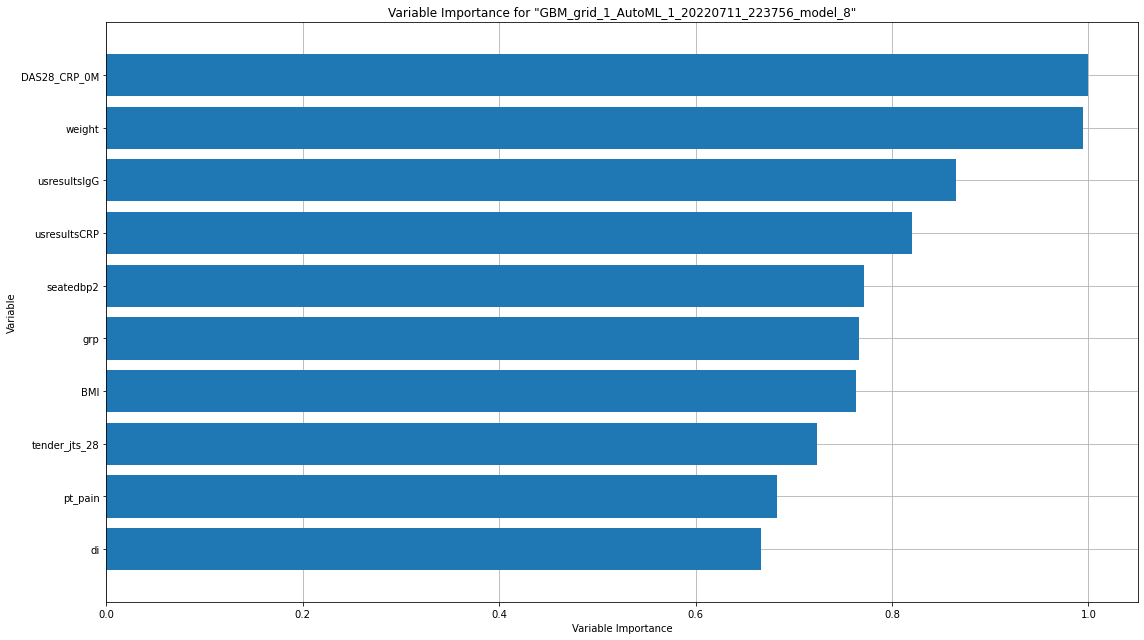

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

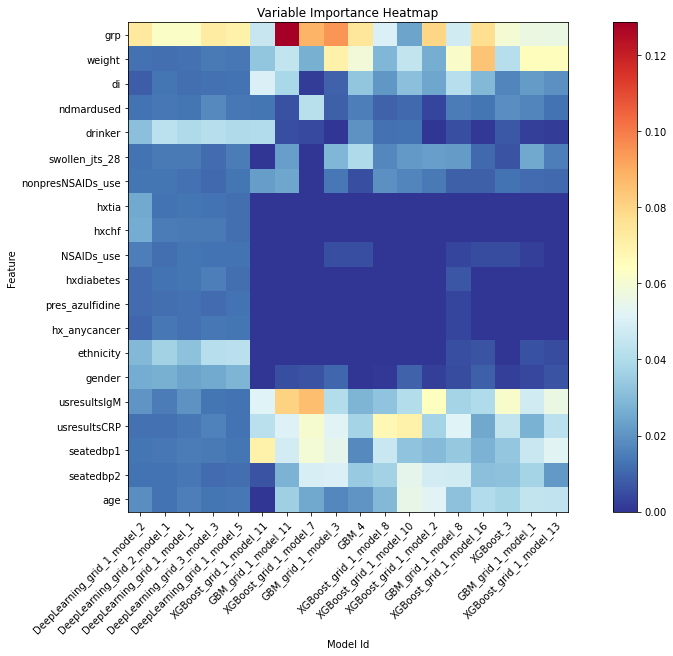

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


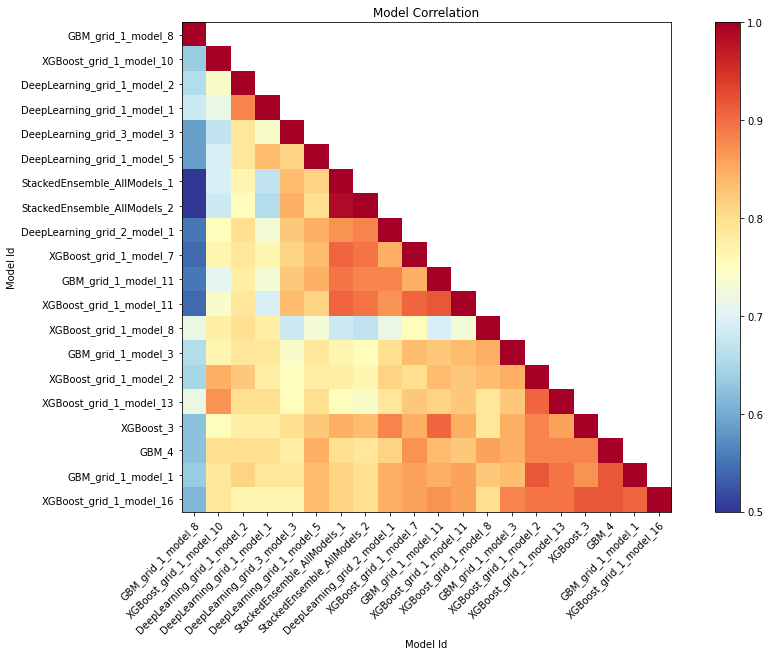

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

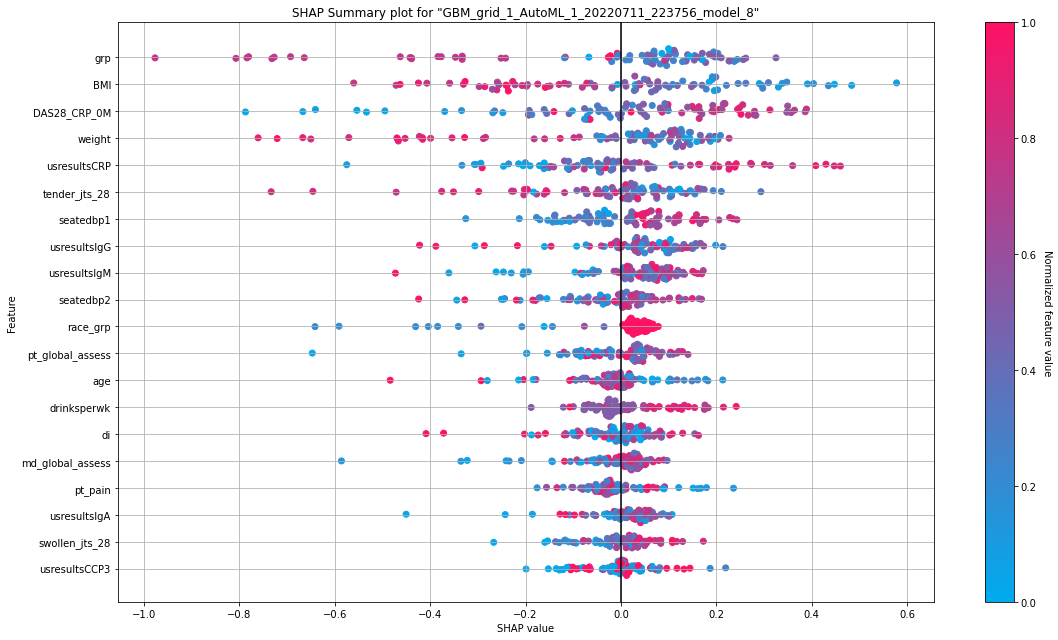

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

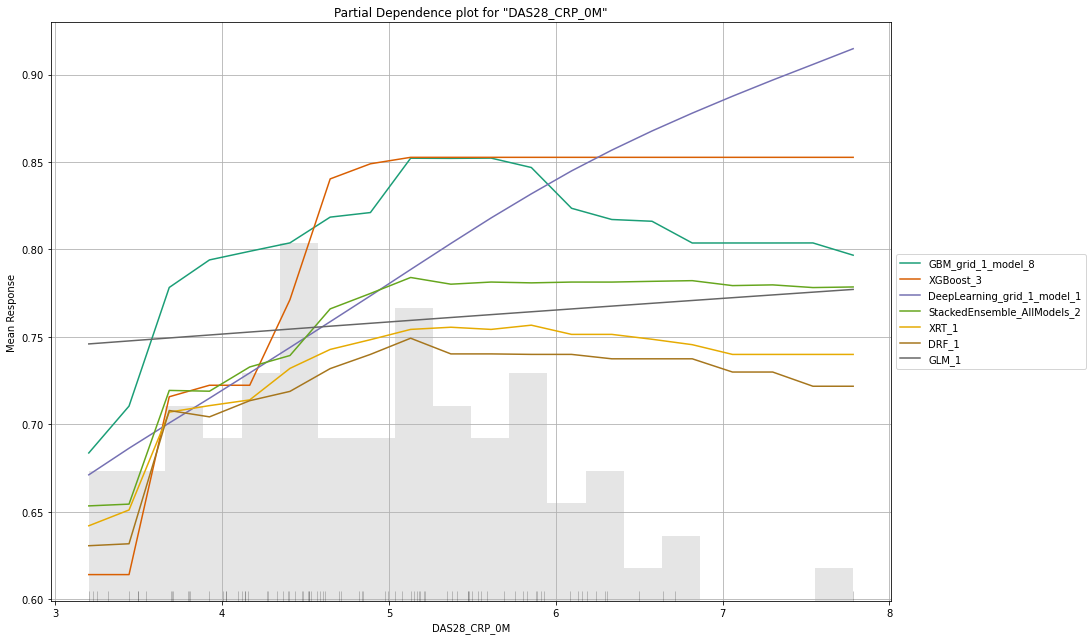

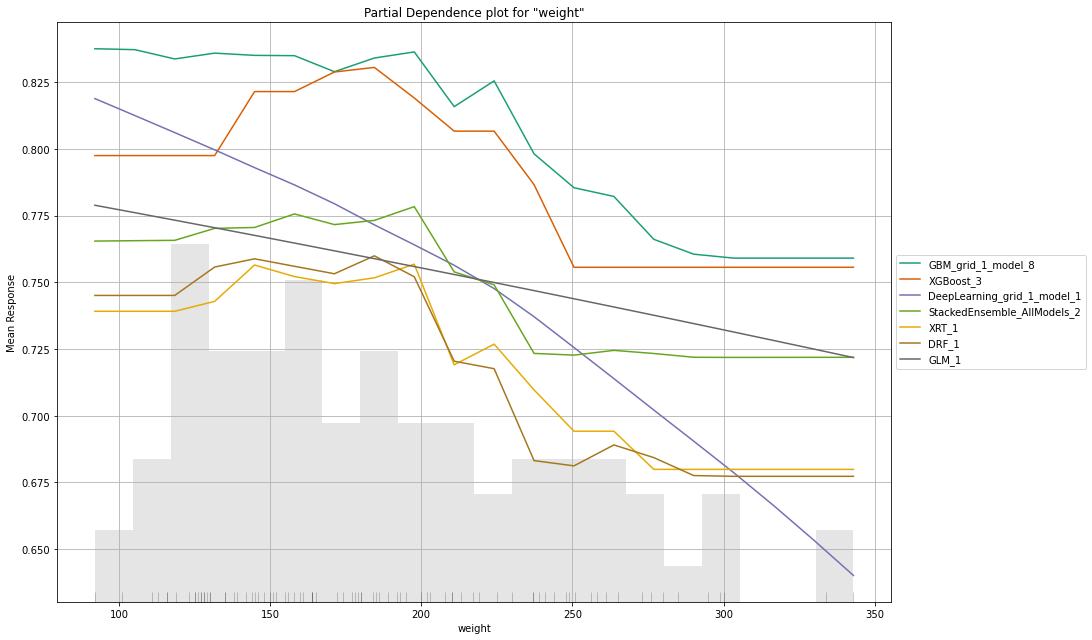

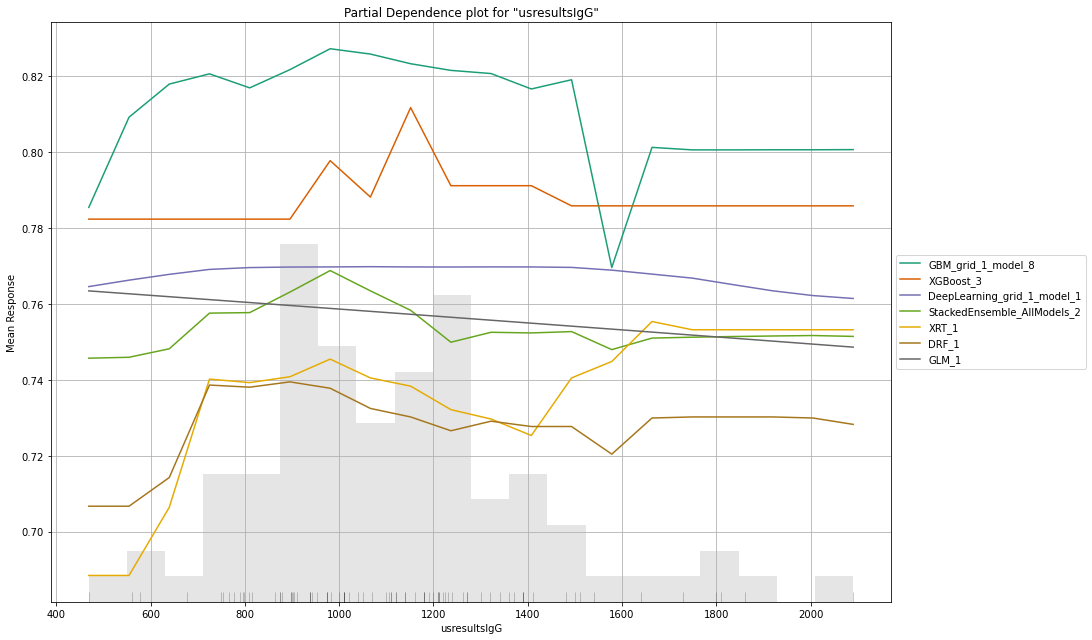

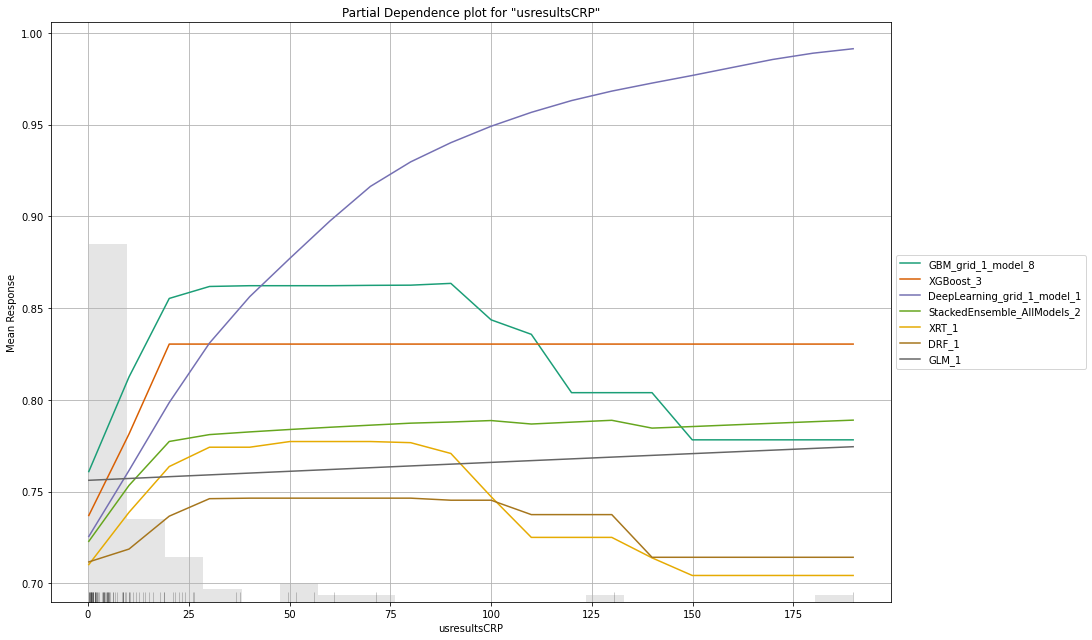

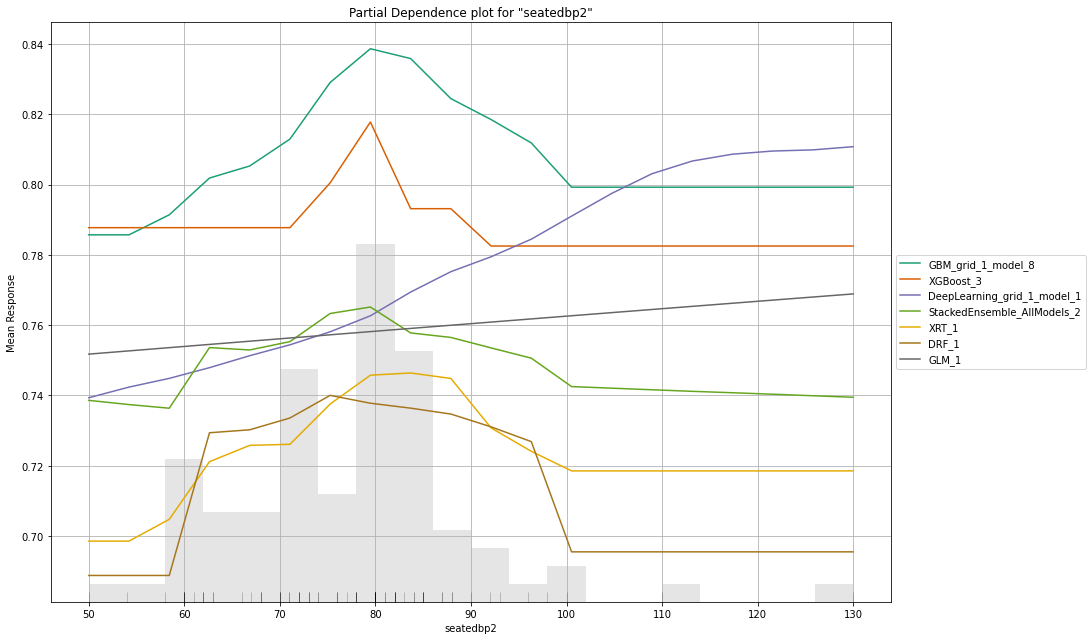

In [21]:
# Explain an AutoML object
exa = aml.explain(test_h2o)